Epoch 1/10
25/25 [==============================] - 1s 8ms/step - loss: 2.9908 - val_loss: 1.3871
Epoch 2/10
25/25 [==============================] - 0s 3ms/step - loss: 1.0477 - val_loss: 1.0179
Epoch 3/10
25/25 [==============================] - 0s 3ms/step - loss: 0.7557 - val_loss: 0.8920
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: 0.6184 - val_loss: 0.8673
Epoch 5/10
25/25 [==============================] - 0s 3ms/step - loss: 0.5237 - val_loss: 0.8589
Epoch 6/10
25/25 [==============================] - 0s 3ms/step - loss: 0.4540 - val_loss: 0.8530
Epoch 7/10
25/25 [==============================] - 0s 3ms/step - loss: 0.3949 - val_loss: 0.8585
Epoch 8/10
25/25 [==============================] - 0s 3ms/step - loss: 0.3422 - val_loss: 0.8560
Epoch 9/10
25/25 [==============================] - 0s 3ms/step - loss: 0.2958 - val_loss: 0.8725
Epoch 10/10
7/7 [==============================] - 0s 1ms/step - loss: 0.8631
Test Loss: 0.8631393313407898
1/1 [=====

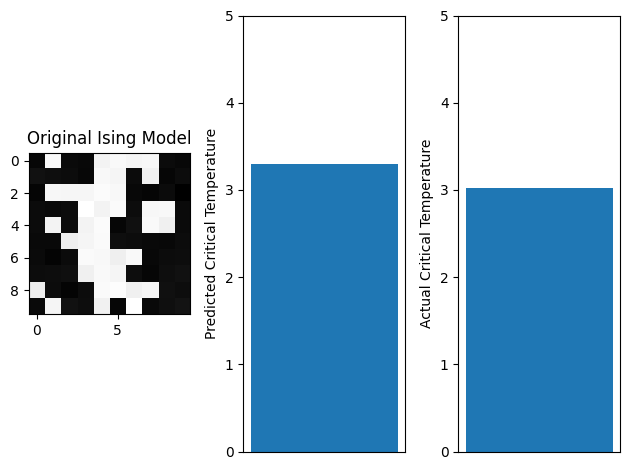

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate Ising model data
def generate_ising_data(size, num_samples):
    data = []
    labels = []
    for _ in range(num_samples):
        lattice = np.random.choice([-1, 1], size=(size, size))
        data.append(lattice)
        labels.append(critical_temperature(lattice))
    return np.array(data), np.array(labels)

def critical_temperature(lattice):
    temperature_range = np.linspace(1.0, 5.0, num=100)  # Range of temperatures to test
    magnetization = []

    for temperature in temperature_range:
        beta = 1.0 / temperature  # Calculate the inverse temperature

        for _ in range(5):  # Number of Monte Carlo steps
            # Perform a Monte Carlo update on the lattice
            for _ in range(size*size):
                i = np.random.randint(0, size)
                j = np.random.randint(0, size)
                spin = lattice[i, j]

                # Calculate the change in energy
                delta_energy = 2 * spin * (lattice[(i+1)%size, j] + lattice[(i-1)%size, j] +
                                           lattice[i, (j+1)%size] + lattice[i, (j-1)%size])

                # Accept or reject the spin flip based on the Metropolis criterion
                if delta_energy < 0 or np.random.random() < np.exp(-beta * delta_energy):
                    lattice[i, j] = -spin

        # Calculate the magnetization at each temperature
        magnetization.append(np.abs(np.sum(lattice)) / (size*size))

    # Find the temperature at which the magnetization is closest to 0.5 (critical temperature)
    critical_temperature = temperature_range[np.argmin(np.abs(np.array(magnetization) - 0.5))]
    return critical_temperature

# Ising model parameters
size = 10
num_samples = 1000

# Generate Ising model data
data, labels = generate_ising_data(size, num_samples)

# Reshape data to fit the DNN input shape
data = data.reshape(num_samples, -1)

# Split the data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2)

# Normalize the features
mean = np.mean(features_train, axis=0)
std = np.std(features_train, axis=0)
features_train = (features_train - mean) / std
features_test = (features_test - mean) / std

# Define the DNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(size*size,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(features_train, labels_train, epochs=10, batch_size=32, validation_data=(features_test, labels_test))

# Evaluate the model
loss = model.evaluate(features_test, labels_test)
print("Test Loss:", loss)

# Generate a new Ising model lattice for prediction
new_input = np.random.choice([-1, 1], size=(size, size))
new_input = new_input.reshape(1, -1)
new_input = (new_input - mean) / std

# Predict the critical temperature for the new lattice using the trained model
prediction = model.predict(new_input)[0][0]

# Calculate the actual critical temperature using Monte Carlo simulation
actual_critical_temperature = critical_temperature(new_input.reshape(size, size))

# Plot the original Ising model lattice
plt.subplot(131)
plt.imshow(new_input.reshape(size, size), cmap='gray')
plt.title("Original Ising Model")

# Plot the predicted critical temperature
plt.subplot(132)
plt.bar(0, prediction, width=0.5)
plt.ylim([0, 5])  # Adjust the y-axis limits as needed
plt.xticks([])
plt.ylabel("Predicted Critical Temperature")

# Plot the actual critical temperature
plt.subplot(133)
plt.bar(0, actual_critical_temperature, width=0.5)
plt.ylim([0, 5])  # Adjust the y-axis limits as needed
plt.xticks([])
plt.ylabel("Actual Critical Temperature")

plt.tight_layout()
plt.show()
